In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mcmc_samplers import SGHMCSampler,LossModule
from ResForkNet import *
import utils as ut
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from collections import OrderedDict
import matplotlib.pyplot as plt
import hiddenlayer as hl
from IPython.display import display, clear_output
import os
import time
torch.manual_seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

plt.style.use('ggplot')

cpu


In [20]:
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX',
         'EA','NFLX','VZ','ACN','ADBE','AMD','ADI','AKAM','AMAT','CSCO','CTXS','IBM','MSI','ORCL','QCOM','WU']
window = 30
pred_window = 30
num_f = 60
transform = ut.ToTensor()
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = window, pred_window = pred_window,transform = transform)
loader = DataLoader(dataset, batch_size=len(dataset),shuffle=False, num_workers=0)
model = ResForkNet(n_dependents = len(stocks), num_inputs = num_f, timesteps = window, num_channels = [128]*2, ll_sizes=[10,100,64])
preds = []

for f,file_model in enumerate(os.listdir("Models/mm")):
    start = time.time()
    model.load_state_dict(torch.load('Models/mm/{}'.format(file_model),map_location = torch.device(device)))
    model = model.to(device)
    #"""
    trains = []
    for i in range(len(dataset.merged_df)-window-pred_window, len(dataset.merged_df)-window):
        stack = []
        for j in range(0,len(dataset.merged_df.columns), num_f):
            stack.append(np.transpose(dataset.norm_df[i:window+i, j:j+num_f]))

        stack = np.concatenate(stack, axis = 1)
        trains.append(stack)
    new_data = np.array(trains)
    #"""
    
    with torch.no_grad():
        test_data,test_labels,index = next(iter(loader))
        #test_data, test_labels, index = test_data[:-50], test_labels[:-50], index[:-50]
        test_data = torch.cat([test_data.to(device), torch.Tensor(new_data).type(torch.FloatTensor).to(device)], axis = 0)
        predictions = model(test_data)
    preds.append(torch.unsqueeze(predictions,0))
    end = time.time()
    print("",end="\r")
    print("Processed File {} of {}, time taken: {} mins".format(f+1, len(os.listdir("Models/mm")), (end-start)//60),end="")
preds = torch.cat(preds, dim=0)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3308, 60, 810) (3308, 27)
Processed File 30 of 30, time taken: 16.0 mins

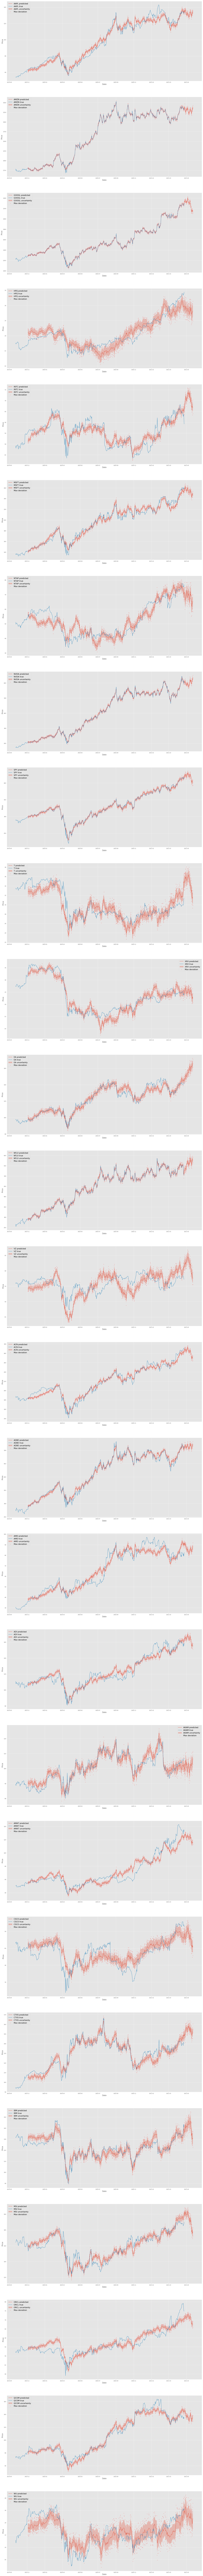

In [26]:
import datetime
days = 400
index_true = [datetime.datetime(index[i,2],index[i,1],index[i,0]) for i in range(index.shape[0])]
index_pred = index_true + [index_true[-1] + datetime.timedelta(days=i) for i in range(1,31)]
fig, axs = plt.subplots(len(stocks),1, figsize=(30,len(stocks)*15))
for i,ax in enumerate(axs):
    avg = torch.mean(preds[:,:,i], dim = 0)
    q95 = np.percentile(preds[:,:,i].numpy(), 95, axis = 0)
    q05 = np.percentile(preds[:,:,i].numpy(), 5, axis = 0)
    q0 = np.min(preds[:,:,i].numpy(), axis = 0)
    q100 = np.max(preds[:,:,i].numpy(), axis = 0)
    
    ax.plot(index_pred[-days:],avg[-days:].detach().cpu().numpy(),
            label = stocks[i]+" predicted")
    ax.fill_between(index_pred[-days:], q95[-days:], q05[-days:], alpha = 0.3, label = stocks[i]+" uncertainty")
    ax.scatter(index_pred[-days:], q0[-days:], marker='x', s = 1.4, c='r', label='Max deviation')
    ax.scatter(index_pred[-days:], q100[-days:], marker='x', s = 1.4, c='r')
    ax.plot(index_true[-days:],test_labels[-days:,i].detach().cpu().numpy(),
            label = stocks[i]+" true")
    ax.set_xlabel('Date',fontsize=16)
    ax.set_ylabel('Price',fontsize=16)
    ax.legend(fontsize=16)
plt.savefig("Stocks.png")
plt.show()